<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/CNN/DUDL_CNN_CNN4MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# Import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[: ,0]
data   = data[:, 1:]

# normalize the data to a range of [0 1]
data_norm = data / np.max(data)

# Reshape to 2D (CNN) - Number of image - Channel - Height - Width
data_norm = data_norm.reshape(data_norm.shape[0], 1, 28, 28)

In [3]:
data_norm.shape

(20000, 1, 28, 28)

# Create train/test groups using DataLoader

In [4]:
# Convert to tensor
data_tensor   = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

#  Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_tensor, labels_tensor, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

In [5]:
# check size (should be images X channels X width X height)
train_loader.dataset.tensors[0].shape

torch.Size([18000, 1, 28, 28])

# Create the DL model

In [7]:
def create_the_MNIST_net(print_toggle=False):
    """
    CNN_MNIST
    """

    class mnist_net(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()
            # Output Image size(Conv + Pool) = (Floor((Input + 2 * Padding - Filter) / Stride) + 1) / Pool

            # Convolution layers. Not put Pooling layer here, do not have parameter.
            self.conv1 = nn.Conv2d(1,  10, kernel_size=5, stride=1, padding=1) # Out(Max + Pool) = 13
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1) # Out(Max + Pool) = 5

            # Compute the number of units in FClayer
            expect_size = np.floor((5 + 2 * 0 - 1) / 1) + 1 # FC1 layer has no padding or kernel, so set to 0/1
            expect_size = 20 * int(expect_size ** 2)        # 20 feature maps comes from conv2

            # Fully-connected layer
            self.fc1 = nn.Linear(expect_size, 50)

            # Output layer
            self.out = nn.Linear(50, 10)

            # Toggle for printing out tensor sizes during forward prop
            self.print = print_toggle
        
        # Forward pass
        def forward(self, x):
            
            print(f'Input: {x.shape}') if self.print else None

            # Convolution -> Maxpool -> Relu
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None

            # Convolution -> Maxpool -> Relu
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None

            # Reshape for Linear layer
            n_units = x.shape.numel() / x.shape[0] # Numbers in X / Number of data samples
            x       = x.view(-1, int(n_units))     # Number of images / Number of units
            if self.print: print(f'Vectorized: {x.shape}')

            # Linear layer
            x = F.relu(self.fc1(x))
            if self.print: print(f'Layer fc1: {x.shape}')
            x = self.out(x)
            if self.print: print(f'Layer out: {x.shape}')

            return x
        
    # Create the model instance
    net = mnist_net(print_toggle)

    # Loss function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

    return net, loss_func, optimizer

In [8]:
# Test the model with one batch
net, loss_func, optimizer = create_the_MNIST_net(print_toggle=True)
X, y  = iter(train_loader).next()
y_hat = net(X)

# Check sizes of model outputs and target variable
print('')
print(y_hat.shape)
print(y    .shape)

# Now let's compute the loss
loss = loss_func(y_hat, y)
print('')
print(f'Loss: {loss}')

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorized: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32])

Loss: 2.2849011421203613


In [16]:
# count the total number of parameters in the model
summary(net, (1, 28, 28))

Input: torch.Size([2, 1, 28, 28])


RuntimeError: ignored

# Create a function that trains the model

In [17]:
def train_the_model():
    """
    FFN_NONMNIST, FFN_BINARIZED MNIST, CNN_MNIST
    """
    
    num_epochs = 60

    # Create a new model
    net, loss_func, optimizer = create_the_MNIST_net()

    # Initialize
    losses    = torch.zeros(num_epochs)
    train_acc = []
    test_acc  = []

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        net.train()
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:
            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(y_hat, axis=1) == y       # Booleans (True/False)
            matches_numeric = matches.float()                # Convert to numbers (1/0)
            accuracy_pct = 100 * torch.mean(matches_numeric) # Average and *100
            batch_acc.append(accuracy_pct)                   # Add to list of accuracies
        # End of batch loop.

        # Get the average training accuracy of the batches
        train_acc.append(np.mean(batch_acc))

        # The average losses accross the batches
        losses[epoch_i] = np.mean(batch_loss)

        # Test accuracy
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        y_hat = net(X)
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    # End epochs

    return train_acc, test_acc, losses, net

# Run the model and show the results!

In [18]:
train_acc, test_acc, losses, net = train_the_model()

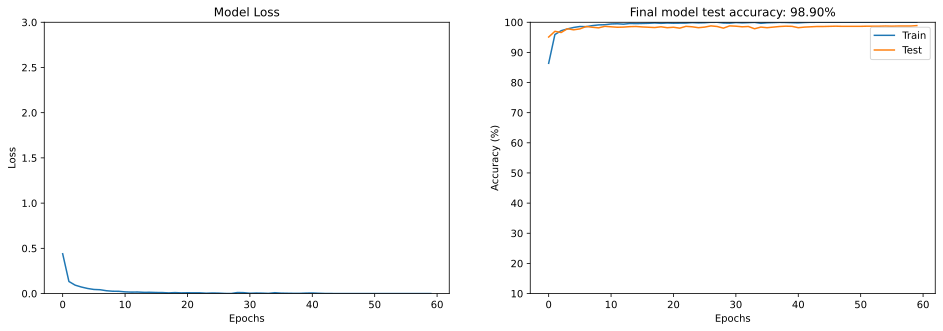

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc,  label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Additional explorations

In [ ]:
# 1) Do we need both convolution layers in this model? Comment out the "conv2" layers in the mode definition. What else
#    needs to be changed in the code for this to work with one convolution layer? Once you get it working, how does the
#    accuracy compare between one and two conv layers? (hint: perhaps try adding some more training epochs)
# 
#    Your observation here is actually the main reason why MNIST isn't very useful for evaluating developments in DL:
#    MNIST is way too easy! Very simple models do very well, so there is little room for variability. In fact, we'll
#    stop using MNIST pretty soon...
# 
#    Final note about MNIST: You probably won't get much higher than 98% with this small dataset. These kinds of CNNs 
#    can get >99% test-accuracy with the full dataset (60k samples instead of 18k).
# 